<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
# print('Tensorflow version:', tf.__version__)
# print('GPU detected:', tf.config.list_physical_devices('GPU'))

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data = pd.read_csv('ner_dataset.csv', encoding='latin1')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [3]:
data.shape

(1048575, 4)

In [4]:
data.dtypes

Sentence #    object
Word          object
POS           object
Tag           object
dtype: object

In [5]:
data.isnull().sum()/len(data)

Sentence #    0.954263
Word          0.000000
POS           0.000000
Tag           0.000000
dtype: float64

In [6]:
# sentence # is assigned only to first word of sentence
# let us assign it to every word in sentence
data = data.fillna(method='ffill')
data.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [7]:
words = list(set(data['Word']))
words.append('ENDPAD')

In [8]:
tags = list(set(data['Tag']))

In [9]:
num_words = len(words)
num_tags = len(tags)
print(f'Unique words: {num_words}\nUnique tags: {num_tags}')

Unique words: 35179
Unique tags: 17


In [10]:
# Let us also count the number of sentences we have
data['Sentence #'].nunique()

47959

In [11]:
# Let us also look at the distribution of our Tag column 
pd.DataFrame({'Percentage of Total (in %)': data['Tag'].value_counts()/len(data)*100})

,Percentage of Total (in %)
O,84.677586
B-geo,3.590015
B-tim,1.939108
B-org,1.920988
I-per,1.645185
B-per,1.620294
I-org,1.600648
B-gpe,1.513483
I-geo,0.707055
I-tim,0.622559


### Retrieve Sentences and Corresponsing Tags

In [12]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        
        agg_func = lambda s: list(zip(s['Word'], s['POS'], s['Tag']))
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = list(self.grouped)
        

In [13]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [14]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

### Define Mappings between Sentences and Tags

In [15]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [16]:
word2idx

{'Suraiwi': 1,
 'Dora': 2,
 'Dravid': 3,
 'Boat': 4,
 'first-class': 5,
 'secessionist': 6,
 'buzzard': 7,
 'Azeglio': 8,
 'Legal': 9,
 'counter-attacks': 10,
 'granddaughter': 11,
 'non-ethnic': 12,
 'anti-drug': 13,
 'Anura': 14,
 'Pironkova': 15,
 'neutrality': 16,
 'Feb.': 17,
 'variations': 18,
 'Hainan': 19,
 'Shepel': 20,
 'reconstruct': 21,
 'macro-economic': 22,
 'U.N.-sponsored': 23,
 'Whale': 24,
 'side-by-side': 25,
 'enjoying': 26,
 'Physician': 27,
 'simultaneous': 28,
 'inhuman': 29,
 'Yardenna': 30,
 'Nangarhar': 31,
 'Commission': 32,
 'Prizes': 33,
 'Frontline': 34,
 'hampered': 35,
 'designing': 36,
 'composer': 37,
 '1820s': 38,
 "Ha'aretz": 39,
 'elusive': 40,
 'Max': 41,
 'Policharki': 42,
 'mats': 43,
 'Indian-controlled': 44,
 'Loj': 45,
 'seminar': 46,
 'Crowley': 47,
 'pheasants': 48,
 'milk': 49,
 'Hidalgo': 50,
 'prohibits': 51,
 'five-seat': 52,
 'Anni': 53,
 'noses': 54,
 'Jesper': 55,
 'USSR': 56,
 'drawn': 57,
 'MTV': 58,
 'Beatty': 59,
 'polarize': 60,


In [17]:
tag2idx

{'B-org': 0,
 'B-tim': 1,
 'I-org': 2,
 'B-art': 3,
 'I-gpe': 4,
 'I-nat': 5,
 'I-geo': 6,
 'B-geo': 7,
 'O': 8,
 'B-per': 9,
 'B-gpe': 10,
 'I-per': 11,
 'I-tim': 12,
 'I-eve': 13,
 'B-eve': 14,
 'B-nat': 15,
 'I-art': 16}

### Padding Input Sentences and Creating Train/Test Splits

We need to be able to use equal length input sentences. We will pad our inputs to a prespecified length.

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


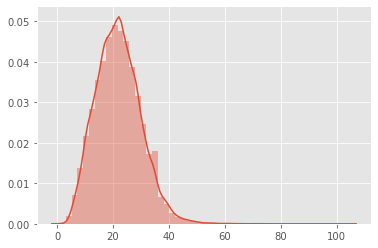

In [18]:
import seaborn as sns
sns.distplot([len(s) for s in sentences])
plt.show()

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

# creating input array
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

# creating target array
y = [[tag2idx[t[2]] for t in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx['O'])
# convert y to one-hot
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [20]:
print(np.array(X).shape)
print(np.array(y).shape)

(47959, 50)
(47959, 50, 17)


We can see that the number of samples corresponds to our number of sentences (47959). Then each sentence has a length of 50, as prespecified earlier. Further, because of one-hot encoding we can see the target array has an extra dimension (there were 17 unique tags as seen earlier). We are good to keep going on.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)                                                    

### Build and Compile a Bidirectional LSTM Model

In [22]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [23]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

### Train the Model

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

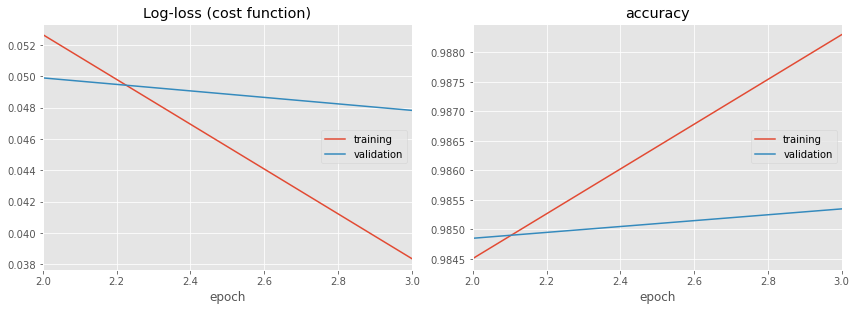

Log-loss (cost function):
training   (min:    0.038, max:    0.190, cur:    0.038)
validation (min:    0.048, max:    0.066, cur:    0.048)

accuracy:
training   (min:    0.957, max:    0.988, cur:    0.988)
validation (min:    0.981, max:    0.985, cur:    0.985)
34530/34530 [==============================] - 116s 3ms/sample - loss: 0.0384 - accuracy: 0.9883 - val_loss: 0.0478 - val_accuracy: 0.9853


In [26]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks=[PlotLossesCallback(), early_stopping]

history = model.fit(X_train, 
                    np.array(y_train), 
                    validation_split=0.2, 
                    batch_size=32, 
                    epochs=3,
                    verbose=1,
                    callbacks=callbacks
                   )

### Evaluate Named Entity Recognition Model

In [27]:
model.evaluate(X_test, np.array(y_test))

4796/4796 [==============================] - 2s 390us/sample - loss: 0.0491 - accuracy: 0.9853


[0.049104503908189163, 0.98527104]